In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



In [60]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.QMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.QMNIST(root='./data', train=False, download=True, transform=transform)

In [61]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [62]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [63]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [64]:
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.1028
Epoch [2/5], Loss: 0.0500
Epoch [3/5], Loss: 0.0322
Epoch [4/5], Loss: 0.5012
Epoch [5/5], Loss: 0.2738


In [65]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

Accuracy on test set: 96.32%


In [66]:
def train_and_evaluate_with_history(model, optimizer, criterion, num_epochs=5):
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = 100 * correct_test / total_test
        test_accuracies.append(test_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%')

    return train_losses, train_accuracies, test_accuracies

In [67]:
class MLP_256(nn.Module):
    def __init__(self):
        super(MLP_256, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x



Hypothesis: 
Increasing the number of nodes to 256 in the hidden layers will likely improve the accuracy on both training and test sets

In [68]:
model = MLP_256()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, train_accuracies, test_accuracies = train_and_evaluate_with_history(model, optimizer, criterion, num_epochs=10)



Epoch [1/10], Loss: 0.3288, Train Acc: 89.97%, Test Acc: 93.55%
Epoch [2/10], Loss: 0.1463, Train Acc: 95.44%, Test Acc: 96.02%
Epoch [3/10], Loss: 0.1106, Train Acc: 96.53%, Test Acc: 96.07%
Epoch [4/10], Loss: 0.0882, Train Acc: 97.20%, Test Acc: 96.67%
Epoch [5/10], Loss: 0.0751, Train Acc: 97.60%, Test Acc: 96.83%
Epoch [6/10], Loss: 0.0648, Train Acc: 97.94%, Test Acc: 96.71%
Epoch [7/10], Loss: 0.0568, Train Acc: 98.15%, Test Acc: 97.25%
Epoch [8/10], Loss: 0.0516, Train Acc: 98.32%, Test Acc: 96.62%
Epoch [9/10], Loss: 0.0481, Train Acc: 98.47%, Test Acc: 96.90%
Epoch [10/10], Loss: 0.0413, Train Acc: 98.64%, Test Acc: 97.51%


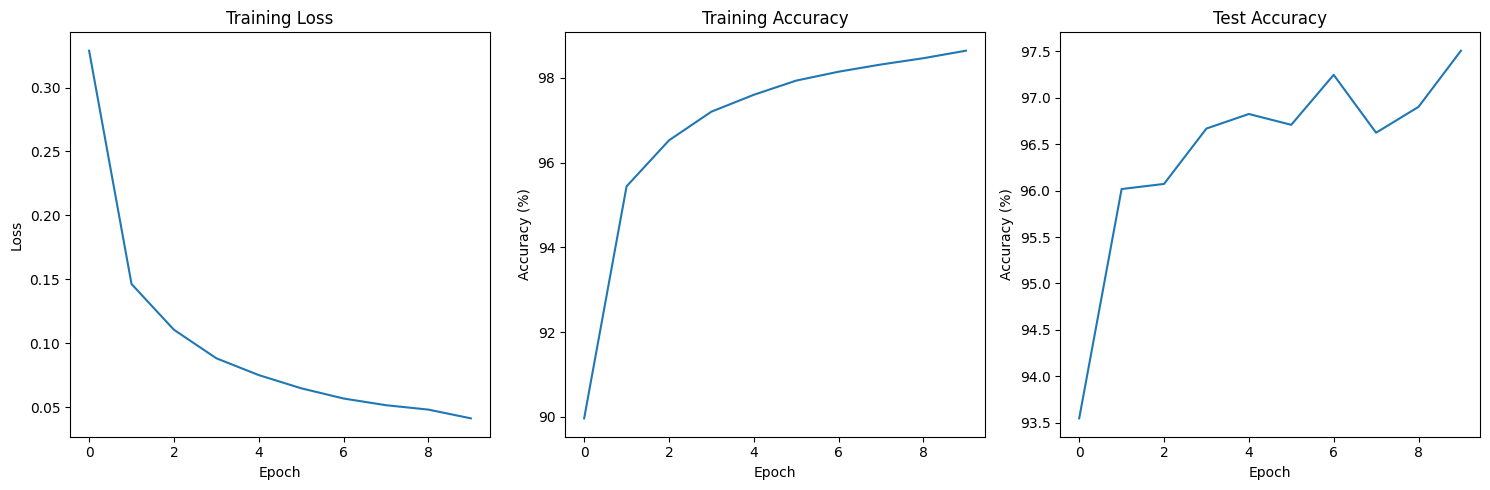

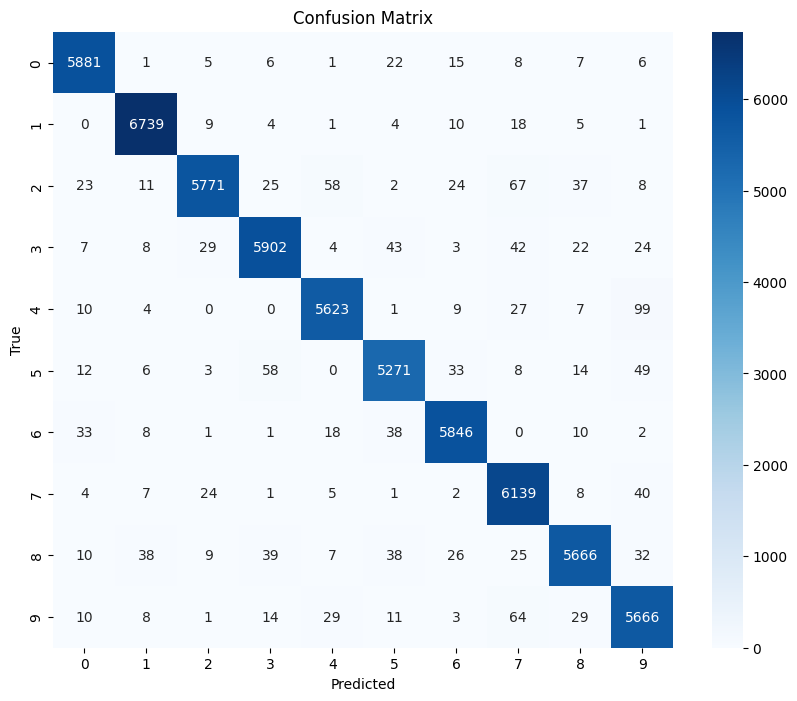

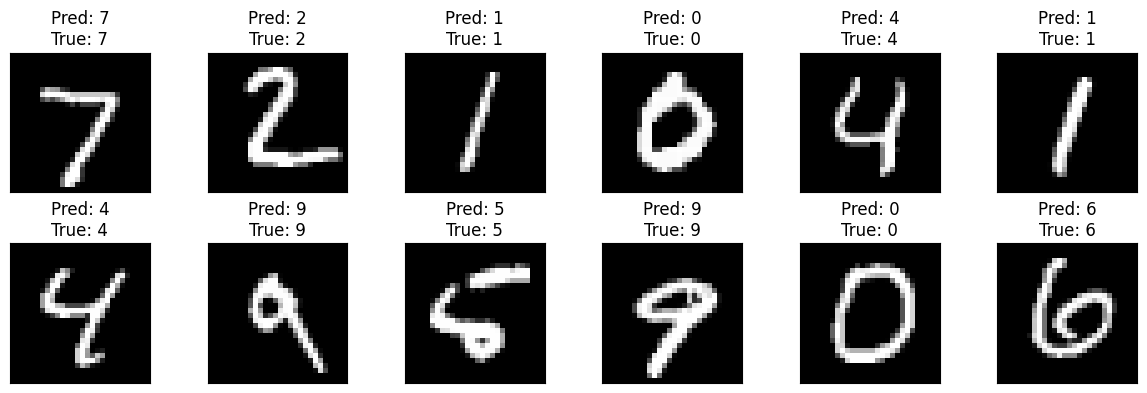

In [69]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(132)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.subplot(133)
plt.plot(test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

model.eval()
images, labels = next(iter(test_loader))
outputs = model(images)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].squeeze().numpy(), cmap='gray')
    ax.set_title(f"Pred: {predicted[i]}\nTrue: {labels[i]}")
plt.tight_layout()
plt.show()

Original MLP:

Final training loss: 0.0963
Test accuracy: 96.15%


Modified MLP_256:

Final training loss: 0.0407
Test accuracy: 97.19%%


The model with 256 nodes has an improved test accuracy.

In [70]:
class MLPWithDropout(nn.Module):
    def __init__(self, activation_fn=nn.ReLU()):
        super(MLPWithDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, 10)
        self.activation = activation_fn

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.activation(self.fc1(x))
        x = self.dropout1(x)
        x = self.activation(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


def train_and_evaluate(model, optimizer, criterion, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on test set: {100 * correct / total:.2f}%')


In [71]:
model_sgd = MLPWithDropout()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()
print("Experiment 1: SGD Optimizer")
train_and_evaluate(model_sgd, optimizer_sgd, criterion)

Experiment 1: SGD Optimizer
Epoch [1/5], Loss: 0.3120
Epoch [2/5], Loss: 0.4900
Epoch [3/5], Loss: 0.1814
Epoch [4/5], Loss: 0.0625
Epoch [5/5], Loss: 0.3193
Accuracy on test set: 96.01%


In [72]:
model_mse = MLPWithDropout()
optimizer = optim.Adam(model_mse.parameters(), lr=0.001)
criterion_mse = nn.MSELoss()

def train_and_evaluate_mse(model, optimizer, criterion, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            labels_one_hot = F.one_hot(labels, num_classes=10).float()
            loss = criterion(outputs, labels_one_hot)
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy on test set: {100 * correct / total:.2f}%')

print("\nExperiment 2: MSE Loss")
train_and_evaluate_mse(model_mse, optimizer, criterion_mse)


Experiment 2: MSE Loss
Epoch [1/5], Loss: 0.0337
Epoch [2/5], Loss: 0.0311
Epoch [3/5], Loss: 0.0439
Epoch [4/5], Loss: 0.0364
Epoch [5/5], Loss: 0.0298
Accuracy on test set: 91.11%


In [73]:
model_tanh = MLPWithDropout(activation_fn=nn.Tanh())
optimizer = optim.Adam(model_tanh.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("\nExperiment 3: Tanh Activation")
train_and_evaluate(model_tanh, optimizer, criterion)


Experiment 3: Tanh Activation
Epoch [1/5], Loss: 0.1773
Epoch [2/5], Loss: 0.3415
Epoch [3/5], Loss: 0.1263
Epoch [4/5], Loss: 0.2926
Epoch [5/5], Loss: 0.1035
Accuracy on test set: 94.98%


In [74]:
class MLPNoDropout(nn.Module):
    def __init__(self):
        super(MLPNoDropout, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [75]:
model_no_dropout = MLPNoDropout()
optimizer = optim.Adam(model_no_dropout.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
print("Experiment 4: No Dropout")
train_and_evaluate(model_no_dropout, optimizer, criterion)

Experiment 4: No Dropout
Epoch [1/5], Loss: 0.1251
Epoch [2/5], Loss: 0.1694
Epoch [3/5], Loss: 0.2118
Epoch [4/5], Loss: 0.1123
Epoch [5/5], Loss: 0.0107
Accuracy on test set: 96.91%
